## Puzzles

In [1]:
import zlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import awkward as ak
from hist import Hist
import uproot
import vector
vector.register_awkward()

<br><br><br>

### NumPy puzzle 1

In [2]:
array3d = np.arange(2 * 3 * 5).reshape(2, 3, 5)

#### Solution

Either keep the number of dimensions intact (the first dimension has length 1):

In [3]:
array3d[:1, :, 2:]

array([[[ 2,  3,  4],
        [ 7,  8,  9],
        [12, 13, 14]]])

or reduce that dimension:

In [4]:
array3d[0, :, 2:]

array([[ 2,  3,  4],
       [ 7,  8,  9],
       [12, 13, 14]])

These are different answers to the question, but both are fine.

<br><br><br>

### NumPy puzzle 2

In [5]:
array = np.array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

#### Solution

This involves slicing and applying a [universal function](https://numpy.org/doc/stable/reference/ufuncs.html) across all elements, showing how NumPy's elementary operations can be combined to get functionality that wasn't explicitly compiled into the library.

In [6]:
array[1:] - array[:-1]

array([1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

<br><br><br>

### NumPy puzzle 3

In [7]:
t = np.linspace(0, 2*np.pi, 10000)
x = np.sin(3*t)
y = np.sin(4*t)

#### Solution

This calculation of path length involves slicing, universal functions, and reduction.

In [8]:
np.sum(np.sqrt((x[1:] - x[-1:])**2 + (y[1:] - y[-1:])**2), axis=0)

9564.961050220914

<br><br><br>

### NumPy puzzle 4

In [9]:
image = matplotlib.image.imread("data/sun-shines-in-CMS.jpg")

#### Solution

In NumPy, the shapes of arrays are fluid. An array can be reshaped from 3 dimensional to 5 dimensional as long as the number of items is unchanged.

Reshaping provides new axes for reducers like [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) to apply.

Be sure to average over axis 3 before axis 1, since reduction removes an axis, changing the numbering of later axes.

In [10]:
resampled = np.mean(
    np.mean(
        image.reshape(1920 // 64, 64, 2560 // 64, 64, 3),
        axis=3,
    ),
    axis=1,
)

Or alternatively, use negative axis numbers and do it in the other order.

In [11]:
resampled = np.mean(
    np.mean(
        image.reshape(1920 // 64, 64, 2560 // 64, 64, 3),
        axis=-4,
    ),
    axis=-2,
)

Or as a third option, use `keepdims=True` to keep the axis numbering from changing and only remove the length 1 dimensions after all reductions are done.

In [12]:
resampled = np.mean(
    np.mean(
        image.reshape(1920 // 64, 64, 2560 // 64, 64, 3),
        axis=1,
        keepdims=True,
    ),
    axis=3,
    keepdims=True,
).reshape(1920 // 64, 2560 // 64, 3)

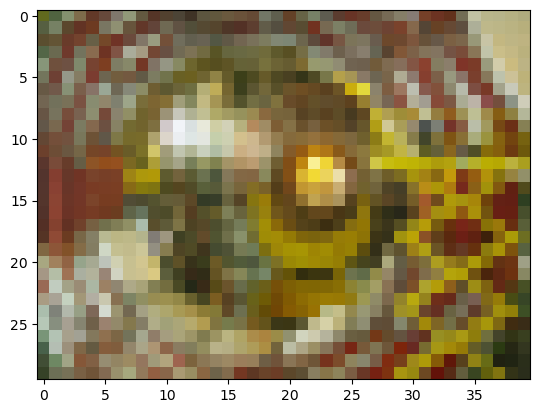

In [13]:
plt.imshow(resampled.astype(np.uint8));

<br><br><br>

### NumPy puzzle 5

In [14]:
with open("data/SMHiggsToZZTo4L.root", "rb") as file:
    file.seek(42104123)
    compressed_data = file.read(14718)
    uncompressed_data = uncompressed_data = zlib.decompress(compressed_data)
    array_of_uint8 = np.frombuffer(uncompressed_data, np.uint8, 12524)

#### Solution

This is similar to the image-scaling puzzle: we use short-lived axes to be able to express an operation, but instead of reduction, it's a direction-reversing slice. Without reshaping, we wouldn't be able to express "groups of 4."

In [15]:
byte_swapped = array_of_uint8.reshape(-1, 4)[:, ::-1].reshape(-1)

In [16]:
byte_swapped.view(np.float32)

array([ 9.831079 , 12.383099 , 12.991788 , ...,  4.3587666,  5.632667 ,
        4.7507796], dtype=float32)

<br><br><br>

### Awkward puzzle 1

In [2]:
with uproot.open("data/SMHiggsToZZTo4L.root") as file:
    dataset = file["Events"].arrays()

In [3]:
EVENT = 0
PARTICLE = 1

In NumPy puzzle 2, you subtracted each element from its neighbor by slicing `array[1:]` (drops the first) and `array[:-1]` (drops the last) before subtracting.

Here, you can do something similar, but it has to apply to the particles axis, not the events axis, so

In [4]:
dataset.Muon_pt[:, :-1] > dataset.Muon_pt[:, 1:]

<Array [[True, True], [], [], ..., [...], [], []] type='299973 * var * bool'>

(either subtract and compare with zero or just compare one to the next).

We want to know if it's always true that `dataset.Muon_pt[:, :-1] > dataset.Muon_pt[:, 1:]`. We can see by eye that there are some `False` values above, but we can clinch it by

In [5]:
np.all(dataset.Muon_pt[:, :-1] > dataset.Muon_pt[:, 1:])

False

It is not true that the muon $p_T$ values are sorted within each event.

The consequence, for this dataset, is that `dataset.Muon_pt[:, 0]` is not the leading $p_T$ and `0` and `1` are not necessarily the two most relevant muons.

<br><br><br>

### Awkward puzzle 2

Take an event if "any muon $p_T > 50$ GeV (considering all particles)."

In [7]:
boolean_mask_1d = ak.any(dataset.Muon_pt > 50, axis=PARTICLE)
boolean_mask_1d

<Array [True, False, False, ..., False, False, False] type='299973 * bool'>

Take an event if "the maximum muon $p_T > 50$ GeV (over all particles)."

In [8]:
boolean_mask_1d = ak.max(dataset.Muon_pt, axis=PARTICLE) > 50
boolean_mask_1d

<Array [True, None, None, True, ..., False, None, None] type='299973 * ?bool'>

Some of these boolean values are missing because there is no maximum of an empty list, and that missing value (`None`) results in a missing conclusion about whether it is greater than 50 GeV or not.

The missing values can be converted into `False` with [ak.fill_none](https://awkward-array.org/doc/main/reference/generated/ak.fill_none.html)

In [10]:
boolean_mask_1d = ak.fill_none(ak.max(dataset.Muon_pt, axis=PARTICLE) > 50, False)
boolean_mask_1d

<Array [True, False, False, ..., False, False, False] type='299973 * bool'>

Take an event if "the number of muons with $p_T > 50$ GeV is $>= 1$."

In [13]:
boolean_mask_1d = ak.num(dataset.Muon_pt[dataset.Muon_pt > 50]) >= 1
boolean_mask_1d

<Array [True, False, False, ..., False, False, False] type='299973 * bool'>

Take an event if "the number of muons in which '$p_T > 50$ GeV' is true (not zero) $>= 1$."

In [15]:
boolean_mask_1d = ak.count_nonzero(dataset.Muon_pt > 50, axis=PARTICLE) >= 1
boolean_mask_1d

<Array [True, False, False, ..., False, False, False] type='299973 * bool'>

Take an event if "the sum of 'muon $p_T > 50$ GeV' (false = 0, true = 1) over particles is $>= 1$."

In [16]:
boolean_mask_1d = ak.sum(dataset.Muon_pt > 50, axis=PARTICLE) >= 1
boolean_mask_1d

<Array [True, False, False, ..., False, False, False] type='299973 * bool'>

Apply it to the `dataset` as a slice. You get whole events (all fields) back.

In [11]:
dataset[boolean_mask_1d]

<Array [{run: 1, ...}, ..., {run: 1, ...}] type='37410 * {run: int32, lumin...'>

Notice that the total number of events is lower, which is not the case for a particle cut.

<br><br><br>

### Awkward puzzle 3

This answer can have the same variety as puzzle 2 because it asks for any particle satisfying a condition.

In [25]:
ak.any(dataset.Electron_pt > 10, axis=PARTICLE) & ak.any(dataset.Muon_pt > 5, axis=PARTICLE)

<Array [False, False, False, ..., False, False, False] type='299973 * bool'>

<br><br><br>

### Awkward puzzle 4

You can use [ak.num](https://awkward-array.org/doc/main/reference/generated/ak.num.html) or the `nMuon` field of the `dataset`.

In [18]:
selected = dataset[ak.num(dataset.Muon_pt) == 2]

Remember that the first axis is `EVENT` and we want all of them, so select `:`, then the second axis is `PARTICLE`.

In [19]:
mu1 = selected.Muon_pt[:, 0]
mu2 = selected.Muon_pt[:, 1]

In [20]:
mu1

<Array [38.5, 27.4, 43.4, 12.3, ..., 24.2, 9.81, 32.6] type='85838 * float32'>

In [21]:
mu2

<Array [47, 67.7, 43.2, 7.91, ..., 24, 79.5, 25.5, 43.1] type='85838 * float32'>

<br><br><br>

### Awkward puzzle 5

In [25]:
electrons = ak.zip({
    "pt": dataset.Electron_pt,
    "phi": dataset.Electron_phi,
    "eta": dataset.Electron_eta,
    "mass": dataset.Electron_mass,
    "charge": dataset.Electron_charge,
}, with_name="Momentum4D")

In [26]:
muons = ak.zip({
    "pt": dataset.Muon_pt,
    "phi": dataset.Muon_phi,
    "eta": dataset.Muon_eta,
    "mass": dataset.Muon_mass,
    "charge": dataset.Muon_charge,
}, with_name="Momentum4D")

In [27]:
selected_muons = muons[ak.num(muons) == 2]

In [28]:
result = (selected_muons[:, 0] + selected_muons[:, 1]).mass
result

<Array [87.1, 90.5, 89.2, 18.8, ..., 88.8, 27.9, 90.5] type='85838 * float32'>

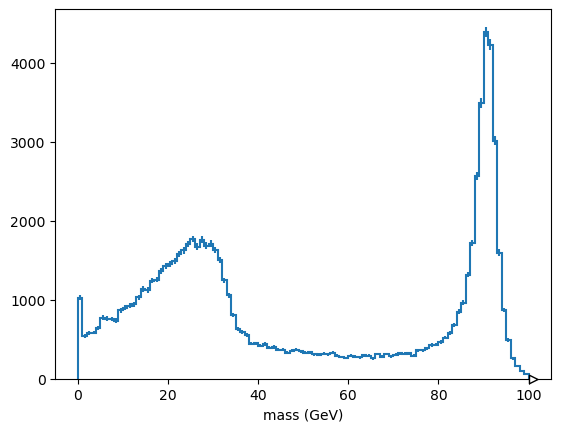

In [32]:
Hist.new.Reg(100, 0, 100, name="mass (GeV)").Double().fill(
    result
).plot();

<br><br><br>